In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import warnings

warnings.filterwarnings("ignore")

In [17]:
# Load the data
df = pd.read_csv(r'C:\Users\44757\Documents\GitHub\IntrotoAI\cleaned_data.csv')

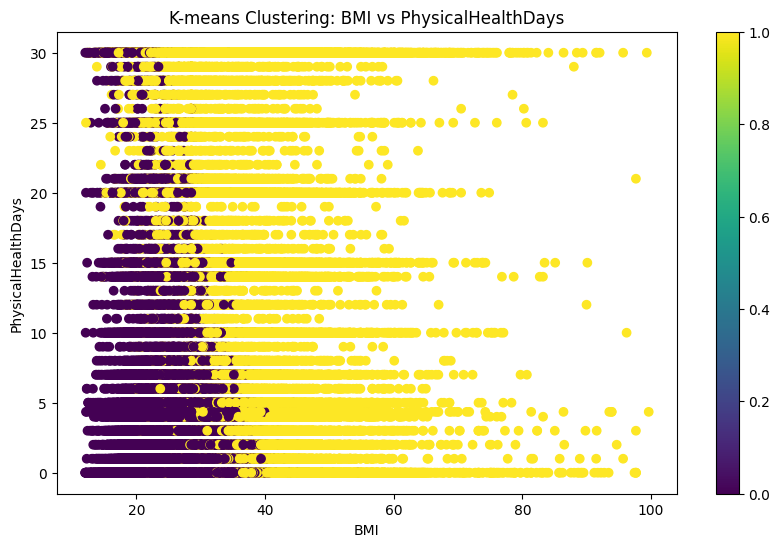

In [ ]:
# Define features
numeric_features = ['BMI', 'PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'WeightInKilograms', 'HeightInMeters']
categorical_features = ['State', 'Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities',
                        'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 
                        'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 
                        'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 
                        'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 
                        'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 
                        'RaceEthnicityCategory', 'AgeCategory', 'AlcoholDrinkers', 'HIVTesting', 
                        'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# Create pipeline with PCA for dimensionality reduction
kmeans_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=10)),  # Adjust n_components as needed
    ('kmeans', MiniBatchKMeans(n_clusters=2, random_state=42))
])

# Fit the pipeline
kmeans_pipeline.fit(df[numeric_features + categorical_features])

# Get cluster labels
cluster_labels = kmeans_pipeline.predict(df[numeric_features + categorical_features])

# Add cluster labels to the dataframe
df['Cluster'] = cluster_labels

# Visualize results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['BMI'], df['PhysicalHealthDays'], c=df['Cluster'], cmap='viridis')
plt.colorbar(scatter)
plt.title('K-means Clustering: BMI vs PhysicalHealthDays')
plt.xlabel('BMI')
plt.ylabel('PhysicalHealthDays')
plt.show()

# Elbow method to find optimal number of clusters
inertias = []
silhouette_scores = []
k_range = range(2, 6)  # Reduced range

for k in k_range:
    kmeans_pipeline.set_params(kmeans__n_clusters=k)
    kmeans_pipeline.fit(df[numeric_features + categorical_features])
    inertias.append(kmeans_pipeline.named_steps['kmeans'].inertia_)
    
    # Calculate silhouette score
    cluster_labels = kmeans_pipeline.predict(df[numeric_features + categorical_features])
    silhouette_scores.append(silhouette_score(kmeans_pipeline.named_steps['preprocessor'].transform(df[numeric_features + categorical_features]), cluster_labels))

# Plot elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')

plt.tight_layout()
plt.show()

# Print cluster centroids
centroids = kmeans_pipeline.named_steps['kmeans'].cluster_centers_
feature_names = (numeric_features + 
                 kmeans_pipeline.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_features).tolist())

print("Cluster Centroids:")
for i, centroid in enumerate(centroids):
    print(f"Cluster {i}:")
    for j, feature in enumerate(feature_names):
        print(f"  {feature}: {centroid[j]:.4f}")
    print()

# Analyze clusters
print("Cluster Analysis:")
for cluster in df['Cluster'].unique():
    cluster_data = df[df['Cluster'] == cluster]
    print(f"Cluster {cluster}:")
    print(cluster_data[numeric_features + categorical_features + ['HadHeartAttack']].describe())
    print(f"Heart Attack Rate: {cluster_data['HadHeartAttack'].mean():.2%}")
    print()
